# DDPG
> Experiment list: Param Noise Baseline / Param Noise Constant

In [1]:
import pandas as pd
import numpy as np
import itertools
from tqdm.notebook import tqdm
import pickle

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from collections import defaultdict
import warnings
from sklearn.preprocessing import LabelEncoder
import random
from datetime import datetime
import pytz
import line_profiler
from functools import reduce

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Fix Random Seeds

In [2]:
def same_seeds(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
  np.random.seed(seed)  
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

same_seeds(0)

## Prepare Data

### Available Files

||Title|File Name|
|---|-----|---------|
|order|Stream group by streamers|`streamer_stream_dict.pkl`|
||Stream list|`stream_list.pkl`|
|Context|Final user context|`user_context.pkl`|
||Streamer context|`streamer.pkl`|
||Item context|`item_pca_df.pkl`|
|Aux|stream: items list|`stream_item_dict.pkl`|
||stream: users list|`stream_users_dict.pkl`|
||item list the consumer actually bought|`user_bought_dict.pkl`|
|Explore-Diff|PCA based diff vector|`diff_vectors_pca.pkl`|
||SVD based diff vector|`diff_vectors_svd.pkl`|
||VAE based diff vector|`diff_vectors_vae.pkl`|
|Threshold|VAE reconstruction error df|`vae_recons_df.pkl`|

In [3]:
# STREAMER_STREAM_DICT = pd.read_pickle('../../data/streamer_stream_dict.pkl')
STREAM_LIST = pd.read_pickle('../../data/stream_list.pkl')
USER_CONTEXT = pd.read_pickle('../../data/user_context.pkl')
# STREAMER = pd.read_pickle('../../data/streamer.pkl')
ITEM_PCA_DF = pd.read_pickle('../../data/item_pca_df.pkl')
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')
USER_BOUGHT_DICT = pd.read_pickle('../../data/user_bought_dict.pkl')
STREAM_USER_DICT = pd.read_pickle('../../data/stream_users_dict.pkl')
# Current used diff
ITEM_DIFF = pd.read_pickle('../../data/item_diff_vectors.pkl')
STREAM_ORDER_CNT = pd.read_pickle('../../data/stream_order_cnt_list.pkl')

In [4]:
DIFF_PCA = pd.read_pickle('../../data/diff_vectors_pca.pkl')
# DIFF_SVD = pd.read_pickle('../../data/diff_vectors_svd.pkl')
# DIFF_VAE = pd.read_pickle('../../data/diff_vectors_vae.pkl')
# VAE_RECONS_DF = pd.read_pickle('../../data/vae_recons_df.pkl')
# VAE_RECONS64_DF = pd.read_pickle('../../data/vae_recons_64_df.pkl')
# MUL150_PCA = pd.read_pickle('../../data/mul150_pca_diff.pkl')
# MUL150_VAE = pd.read_pickle('../../data/mul150_vae_diff.pkl')
# MUL64_PCA = pd.read_pickle('../../data/mul64_pca_diff.pkl')
# MUL64_VAE = pd.read_pickle('../../data/mul64_vae_diff.pkl')

---

## Replay

In [5]:
class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        self.data = [None for _ in range(maxlen)]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]

    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length.
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item.
            self.start = (self.start + 1) % self.maxlen
        else:
            # This should never happen.
            raise RuntimeError()
        self.data[(self.start + self.length - 1) % self.maxlen] = v

class ReplayBuffer:
  def __init__(self, limit=10000):
    self.limit = limit
    # init 4 RingBuffers: states/actions/rewards/ongoing
    self.states_buffer = RingBuffer(limit)
    self.next_states_buffer = RingBuffer(limit)
    self.actions_buffer = RingBuffer(limit)
    self.rewards_buffer = RingBuffer(limit)
    self.ongoings_buffer = RingBuffer(limit)
    
  def __len__(self):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    return len(self.states_buffer)

  def remember(self, state, actions, reward, next_state, ongoing):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    # append each element separately in different list
    self.states_buffer.append(state)
    self.actions_buffer.append(actions)
    self.rewards_buffer.append(reward)
    self.next_states_buffer.append(next_state)
    self.ongoings_buffer.append(ongoing)
    
  def get_batch(self, batch_size=100):
    assert len(self.states_buffer) == len(self.next_states_buffer) == len(self.actions_buffer) == \
           len(self.rewards_buffer) == len(self.ongoings_buffer)
    # same for sample_and_split
    states0_batch = []
    states1_batch = []
    actions_batch = []
    rewards_batch = []
    ongoings_batch = []
    batch_indexs = np.random.randint(0, len(self.states_buffer), size=min(len(self.states_buffer), batch_size))
    for i in batch_indexs:
      states0_batch.append(USER_CONTEXT.xs(self.states_buffer[i]))
      states1_batch.append(USER_CONTEXT.xs(self.next_states_buffer[i]))
      actions_batch.append(self.actions_buffer[i])
      rewards_batch.append(self.rewards_buffer[i])
      ongoings_batch.append(self.ongoings_buffer[i])
    assert len(states0_batch) == len(states1_batch) == len(actions_batch) == \
           len(rewards_batch) == len(ongoings_batch)
    return np.array(states0_batch), np.array(actions_batch), np.array(rewards_batch), np.array(states1_batch), np.array(ongoings_batch)

## Random Process

In [6]:
class RandomProcess(object):
    def reset_states(self):
        pass

class AnnealedGaussianProcess(RandomProcess):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.reset_states()

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

    def reset_states(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

## Models

In [7]:
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, mode, hidden1=400, hidden2=300, init_w=3e-3):
        super(Actor, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(state_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, action_dim)
        self.norm1 = nn.LayerNorm(hidden1)
        self.norm2 = nn.LayerNorm(hidden2)
        self.norm3 = nn.LayerNorm(action_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.norm3(out)
        out = self.tanh(out)
        return out

    def add_parameter_noise(self, scalar=.1):
        self.fc1.weight.data += torch.randn_like(self.fc1.weight.data) * scalar
        self.fc2.weight.data += torch.randn_like(self.fc2.weight.data) * scalar
        self.fc3.weight.data += torch.randn_like(self.fc3.weight.data) * scalar

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden1=400, hidden2=300, init_w=3e-3):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden1)
        self.fc2 = nn.Linear(hidden1+action_dim, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.init_weights(init_w)
    
    def init_weights(self, init_w):
        self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())
        self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())
        self.fc3.weight.data.uniform_(-init_w, init_w)
    
    def forward(self, xs):
        x, a = xs
        out = self.fc1(x)
        out = self.relu(out)
        # debug()
        out = self.fc2(torch.cat([out,a],1))
        out = self.relu(out)
        out = self.fc3(out)
        return out

## DDPG

In [8]:
def to_tensor(input_df):
  return torch.tensor(input_df).to(DEVICE).float()

class DDPG(object):
  def __init__(self, actor_lr, critic_lr, state_dim, action_dim, mode='baseline',
               hidden1=400, hidden2=300, diff_multiplier=1,
               top_k=10, max_memory=10000, depsilon=50000, discount=0.99,
               tau=0.001, batch_size=100, ou_theta=0.15, ou_mu=0.0, ou_sigma=0.2, 
               param_noise_scalar=.05, param_noise_scalar_alpha=1.01, desired_distance=.7):
    # State & Action dimension
    self.state_dim = state_dim
    self.action_dim = action_dim
    
    # Mode settings
    # baseline
    # diff: diff_pca, diff_svd, diff_vae
    # threshold: thres_vae, thres_vdbe
    # multiplier: MUL150_PCA, MUL150_VAE, MUL64_PCA, MUL64_VAE
    # Parameter noise: PARAM_NOISE
    self.mode = mode
    self.diff_multiplier = diff_multiplier
    
    # Param Noise
    self.distances = []
    self.desired_distance = desired_distance
    self.param_noise_scalar = param_noise_scalar
    self.param_noise_scalar_alpha = param_noise_scalar_alpha

    # Init Actor
    self.actor = Actor(state_dim, action_dim, mode, hidden1, hidden2)
    self.actor_noised = Actor(state_dim, action_dim, mode, hidden1, hidden2)
    self.actor_target = Actor(state_dim, action_dim, mode, hidden1, hidden2)
    self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    # Init Critic
    self.critic = Critic(state_dim, action_dim, hidden1, hidden2)
    self.critic_target = Critic(state_dim, action_dim, hidden1, hidden2)
    self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

    # Memory
    self.buffer = ReplayBuffer(limit=max_memory)

    # Exploration
    self.epsilon = 1.0
    self.depsilon = 1.0 / depsilon
    self.random_process = OrnsteinUhlenbeckProcess(size=action_dim, theta=ou_theta, mu=ou_mu, sigma=ou_sigma)

    # Reward related
    self.top_k = top_k
    
    # Loss Function
    self.loss_fn = nn.MSELoss()
    
    # Hyperparameters
    self.discount = discount
    self.tau = tau
    self.batch_size = batch_size

    # Network to cuda
    self.actor.to(DEVICE)
    self.actor_noised.to(DEVICE)
    self.critic.to(DEVICE)
    self.actor_target.to(DEVICE)
    self.critic_target.to(DEVICE)
    
  def random_action(self):
    action = np.random.uniform(-1.,1.,self.action_dim).astype('float32')
    self.action = action
    return action
    
  def generate_latent_action(self, state, decay_epsilon=True, vdbe_epsilon=False):
    action = self.actor(to_tensor(state))
    '''
    Param Noise
    '''
    with torch.no_grad():
      self.actor_noised.load_state_dict(self.actor.state_dict().copy())
      self.actor_noised.add_parameter_noise(self.param_noise_scalar)

      action_noised = self.actor_noised(to_tensor(state))

      distance = torch.sqrt(torch.mean(torch.square(action - action_noised))).cpu().detach().numpy()
      if distance < self.desired_distance:
          self.param_noise_scalar *= self.param_noise_scalar_alpha
      else:
          self.param_noise_scalar /= self.param_noise_scalar_alpha

      action = action_noised
    '''
    Add the diff vector to action
    '''
    if self.mode != 'baseline':
      current_diff = globals()[self.mode.upper()]
      if state.name in current_diff.index:
        # for mode = [diff_pca, diff_svd, diff_vae, MUL150_VAE, MUL64_VAE, ITEM_DIFF]
        action += to_tensor(current_diff.loc[state.name]) * self.diff_multiplier * max(self.epsilon, 0)
    else: action += max(self.epsilon, 0) * torch.tensor(self.random_process.sample()).to(DEVICE).float()
    
    action = torch.clamp(action, -1., 1.).cpu().detach().numpy()

    if decay_epsilon:
      self.epsilon -= self.depsilon
        
    self.action = action
    return action
  
  def get_actions_rewards(self):
    true_list = USER_BOUGHT_DICT[self.curr_user]
    hit_list, rewarded_items = [], set()
    self.action_list = ITEM_PCA_DF.iloc[self.curr_stream_items].apply(lambda x: np.dot(x, self.action), axis=1).nlargest(self.top_k).index
    for a in self.action_list:
      if a in true_list:
        hit_list.append(1)
        rewarded_items.add(a)
      else: hit_list.append(0)
    res = sum(hit_list)
    return res, rewarded_items
    
  def update_policy(self):
    # Sample batch
    state_batch, action_batch, reward_batch, \
    next_state_batch, ongoing_batch = self.buffer.get_batch(self.batch_size)
    
    # Prepare for the target q batch
    next_q_values = self.critic_target([
        to_tensor(next_state_batch).detach(),
        self.actor_target(to_tensor(next_state_batch).detach()),
    ])
    
    # 如果 ongoing 為 True(1) 時，乘以 next_q 會有值
    # 但是 ongoing 為 False(0) 時，乘以 next_q 會等於 0
    target_q_batch = to_tensor(reward_batch).view(next_q_values.shape) + \
                       self.discount*to_tensor(ongoing_batch).view(next_q_values.shape)*next_q_values.detach()

    # Critic update
    self.critic_optim.zero_grad()

    q_batch = self.critic([ to_tensor(state_batch), to_tensor(action_batch) ])

    value_loss = self.loss_fn(q_batch, target_q_batch)
    value_loss.backward()
    self.critic_optim.step()

    # Actor update
    self.actor_optim.zero_grad()

    policy_loss = -self.critic([
        to_tensor(state_batch),
        self.actor(to_tensor(state_batch))
    ])

    policy_loss = policy_loss.mean()
    policy_loss.backward()
    self.actor_optim.step()

    # Target update
    self._soft_update(self.actor_target, self.actor)
    self._soft_update(self.critic_target, self.critic)
    return value_loss, policy_loss
    
  def _soft_update(self, target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - self.tau) + param.data * self.tau
        )

## Main Method

In [9]:
def train(agent, reward_records=[], avg_rewards=[], hit_ratios=[], regret_list=[], coverage_list=[], diversity_list=[], warmup=100, ep_len=4000):
  agent.actor.train(True)
  agent.critic.train(True)
  batch_value_loss, batch_policy_loss = 0., 0.
  step_value_loss, step_policy_loss = 0., 0.
  step = 0
  # self.epsilon.clear()

  # ------------------- Episode (State) -------------------------------
  for stream in tqdm(STREAM_LIST[:3300]):
    # self.__user_episode_context()
    users = STREAM_USER_DICT[stream]

    agent.curr_stream = stream
    agent.curr_stream_items = STREAM_ITEM_DICT[stream]
    batch_value_loss, batch_policy_loss = 0., 0.
    stream_reward = 0
    false_positive_cnt = 0
    diversity_prod_set = set()
    coverage_rewarded_items = set()

    # ----------------- Runs (User under stream) ---------------------
    for i, user in enumerate(users):
      # update step
      step += 1
      
      # state & ongoing
      agent.curr_user = user
      state = USER_CONTEXT.loc[(user, stream)]
      ongoing = i != len(users) - 1

      # --------------- Actor net choose actions ----------------------
      # make actor to choose action
      # action = latent vector
      if step <= warmup:
        action = agent.random_action()
      else:
        action = agent.generate_latent_action(state)
          
      # --------------- Get next state & info to store ---------------
      # Generate reward
      reward, curr_rewarded_items = agent.get_actions_rewards()

      # next_state: next user's state
      next_user = users[i + 1] if i + 1 < len(users) else None
      
      # update metrics
      reward_records.append(reward)
      stream_reward += reward
      false_positive_cnt += (10 - reward)
      coverage_rewarded_items = coverage_rewarded_items | curr_rewarded_items
      diversity_prod_set = diversity_prod_set | set(agent.action_list)
      
      # Remember only when reward > 0 or the memory is short
      if reward > 0 or len(agent.buffer) < 10:
        storing_state = (user, stream)
        storing_next_state = (next_user, stream) if next_user else storing_state
        agent.buffer.remember(storing_state, action, reward, storing_next_state, ongoing)

      # --------------- Train on Actor and Critic --------------------
      # store pre-training value for td_error
      # old_Q = self.q_value()
      if step > warmup :
        step_value_loss, step_policy_loss = agent.update_policy()
      # store post-training value for td_error
      # new_Q = self.q_value()
      batch_value_loss += step_value_loss
      batch_policy_loss += step_policy_loss

      # --------------- Update with TD error -------------------------
      # self.epsilon.update_at_step(self.asid, [(new_Q - old_Q), self.learn_step_counter], 1/len(self.stream_items))

    # --------------- Inspecting result at step -------------------------
    ep_avg_reward = round(sum(reward_records)/step, 2)
    avg_rewards.append(ep_avg_reward)
    
    ground_truth = STREAM_ORDER_CNT.iloc[stream]
    # hit ratio
    hr10 = stream_reward / ground_truth
    hit_ratios.append(hr10)
    # regret
    regret = false_positive_cnt / len(users)
    regret_list.append(regret)
    # coverage
    coverage = len(coverage_rewarded_items) / ground_truth
    coverage_list.append(coverage)
    # diversity
    diversity = len(diversity_prod_set) / len(STREAM_ITEM_DICT[stream])
    diversity_list.append(diversity)
    
    print(f'Stream: {stream}, user_count: {len(users)}, avg_reward@stream: {round(stream_reward/len(users), 2)}, avg_reward: {ep_avg_reward}, \
hr10: {round(hr10, 3)}, regret: {round(regret, 3)}, coverage: {round(coverage, 3)}, diversity: {round(diversity, 3)}, \
batch_value_loss: {round(float(batch_value_loss)/len(users), 3)}')
    
    # if len(reward_records) >= 247581: break

In [10]:
pd.set_option('mode.chained_assignment', None)

actor_lr = 1.0e-3
critic_lr = 1.0e-3
state_dim = USER_CONTEXT.shape[1]
action_dim = ITEM_PCA_DF.shape[1]
hidden1 = 400
hidden2 = 300
diff_multiplier = 1.669861
top_k = 10
max_memory = 10000
depsilon = 50000
discount = 0.99
tau = 0.001
batch_size = 100
ou_theta = 0.15
ou_mu = 0.0
ou_sigma = 0.2
param_noise_scalar = 0.05
param_noise_scalar_alpha = 1.01
desired_distance = 0.7

mode = 'diff_pca'

warnings.simplefilter(action='ignore', category=FutureWarning)

## Execute

In [11]:
ddpg_agent = DDPG(actor_lr, critic_lr, state_dim, action_dim, mode, hidden1, hidden2, diff_multiplier,
                  top_k, max_memory, depsilon, discount, tau, batch_size, ou_theta, ou_mu, ou_sigma, 
                  param_noise_scalar, param_noise_scalar_alpha, desired_distance)
reward_records = []
avg_rewards = []
hit_ratios, regret_list, coverage_list, diversity_list = [], [], [], []
train(ddpg_agent, reward_records, avg_rewards, hit_ratios, regret_list, coverage_list, diversity_list)

  0%|          | 0/3300 [00:00<?, ?it/s]

Stream: 0, user_count: 56, avg_reward@stream: 0.45, avg_reward: 0.45, hr10: 0.333, regret: 9.554, coverage: 0.2, diversity: 1.0, batch_value_loss: 0.0
Stream: 1, user_count: 534, avg_reward@stream: 0.51, avg_reward: 0.51, hr10: 0.164, regret: 9.489, coverage: 0.036, diversity: 1.0, batch_value_loss: 0.054
Stream: 2, user_count: 56, avg_reward@stream: 1.41, avg_reward: 0.58, hr10: 0.782, regret: 8.589, coverage: 0.149, diversity: 1.0, batch_value_loss: 0.077
Stream: 3, user_count: 29, avg_reward@stream: 1.17, avg_reward: 0.61, hr10: 0.739, regret: 8.828, coverage: 0.261, diversity: 1.0, batch_value_loss: 0.057
Stream: 4, user_count: 104, avg_reward@stream: 0.38, avg_reward: 0.58, hr10: 0.263, regret: 9.615, coverage: 0.105, diversity: 0.984, batch_value_loss: 0.031
Stream: 5, user_count: 83, avg_reward@stream: 0.82, avg_reward: 0.6, hr10: 0.756, regret: 9.181, coverage: 0.144, diversity: 1.0, batch_value_loss: 0.013
Stream: 6, user_count: 37, avg_reward@stream: 0.76, avg_reward: 0.61, h

In [13]:
mode

'diff_pca'

---
## Save Result & Model

In [12]:
diff_items = {'mode': f'hybrid_ax_decay_pca.pkl', 'reward_records': reward_records, 'avg_rewards': avg_rewards}

with open(f'results/hybrid_ax_decay_pca.pkl.pkl', 'wb') as handle:
    pickle.dump(diff_items, handle, protocol=pickle.HIGHEST_PROTOCOL)

torch.save(ddpg_agent, f'models/hybrid_ax_decay_pca.pkl.pth')

model = torch.load(f'models/hybrid_ax_decay_pca.pkl.pth')

model.depsilon == ddpg_agent.depsilon

True

---
Previous ver of training method

In [ ]:
# def train(agent, reward_records=[], avg_rewards=[], warmup=100):
#   agent.actor.train(True)
#   agent.critic.train(True)
#   batch_value_loss, batch_policy_loss = 0., 0.
#   step_value_loss, step_policy_loss = 0., 0.
#   step = 0
#   # self.epsilon.clear()

#   # ------------------- Episode (State) -------------------------------
#   for stream in tqdm(STREAM_LIST[:4000]):
#     # self.__user_episode_context()
#     users = STREAM_USER_DICT[stream]
#     agent.curr_stream = stream
#     agent.curr_stream_items = STREAM_ITEM_DICT[stream]
#     stream_reward = 0
#     batch_value_loss, batch_policy_loss = 0., 0.

#     # ----------------- Runs (User under stream) ---------------------
#     for i, user in enumerate(users):
#       # update step
#       step += 1
      
#       # state & ongoing
#       agent.curr_user = user
#       state = USER_CONTEXT.loc[(user, stream)]
#       ongoing = i != len(users) - 1

#       # --------------- Actor net choose actions ----------------------
#       # make actor to choose action
#       # action = latent vector
#       if step <= warmup:
#         action = agent.random_action()
#       else:
#         action = agent.generate_latent_action(state)
          
#       # --------------- Get next state & info to store ---------------
#       # Generate reward
#       reward = agent.get_actions_rewards()

#       # next_state: next user's state
#       next_user = users[i + 1] if i + 1 < len(users) else None
#       # Remember only when reward > 0 or the memory is short
#       reward_records.append(reward)
#       stream_reward += reward
#       if reward > 0 or len(agent.buffer) < 10:
#         storing_state = (user, stream)
#         storing_next_state = (next_user, stream) if next_user else storing_state
#         agent.buffer.remember(storing_state, action, reward, storing_next_state, ongoing)

#       # --------------- Train on Actor and Critic --------------------
#       # store pre-training value for td_error
#       # old_Q = self.q_value()
#       if step > warmup :
#         step_value_loss, step_policy_loss = agent.update_policy()
#       # store post-training value for td_error
#       # new_Q = self.q_value()
#       batch_value_loss += step_value_loss
#       batch_policy_loss += step_policy_loss

#       # --------------- Update with TD error -------------------------
#       # self.epsilon.update_at_step(self.asid, [(new_Q - old_Q), self.learn_step_counter], 1/len(self.stream_items))

#       # --------------- Inspecting result at step -------------------------
#     ep_avg_reward = round(sum(reward_records)/step, 2)
#     avg_rewards.append(ep_avg_reward)
#     print(f'Stream: {stream}, user_count: {len(users)}, \
# sum_rewards: {round(sum(reward_records), 2)},avg_reward@stream: {round(stream_reward/len(users), 2)}, avg_reward: {ep_avg_reward}, \
# batch_value_loss: {round(float(batch_value_loss)/len(users), 3)}, batch_policy_loss: {round(float(batch_policy_loss)/len(users), 3)} | reward_len: {len(reward_records)}')
    
#     if len(reward_records) >= 247581: break

---
## Effect of Diff Vector

In [109]:
item_names = pd.read_pickle('item_names.pkl')

In [117]:
def distance(ddpg_agent, point, actions):
  res = 0
  item = ITEM_PCA_DF.iloc[point]
  for i in range(ddpg_agent.action_dim):
    res += (actions[i] - item.loc[f'i{i}']) ** 2
  return res

In [130]:
user = '1258157967712334'
stream = 7245
state = USER_CONTEXT.loc[user, stream]
diff = ITEM_DIFF.loc[user, stream]
action_with_diff = ddpg_agent.generate_latent_action(state, decay_epsilon=True, vdbe_epsilon=False)
action_without_diff = action_with_diff - diff
curr_stream_items = STREAM_ITEM_DICT[stream]
curr_stream_items.sort(key=lambda p: ddpg_agent._distance(p))
actions_with_diff = curr_stream_items[:min(ddpg_agent.top_k, len(curr_stream_items) - 1)]

curr_stream_items.sort(key=lambda p: distance(ddpg_agent, p, action_without_diff))
actions_without_diff = curr_stream_items[:min(ddpg_agent.top_k, len(curr_stream_items) - 1)]

In [131]:
actions_with_diff, actions_without_diff

([33884, 21463, 33885, 33886, 25414, 33918, 33937, 21450, 3945, 4380],
 [3945, 33886, 33918, 33915, 21463, 33937, 4380, 33892, 25414, 25364])

In [143]:
actions_emb =  ITEM_PCA_DF.iloc[actions_with_diff + actions_without_diff]

[33884,
 21463,
 33885,
 33886,
 25414,
 33918,
 33937,
 21450,
 3945,
 4380,
 3945,
 33886,
 33918,
 33915,
 21463,
 33937,
 4380,
 33892,
 25414,
 25364]

In [149]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
action_pca = pca.fit_transform(actions_emb)

action_pca_df = pd.DataFrame(action_pca, index=actions_with_diff + actions_without_diff)

In [156]:
action_pca_df.shape

(20, 2)

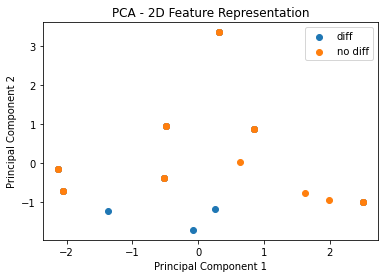

In [161]:
# 绘制降维后的数据
plt.scatter(action_pca_df.loc[actions_with_diff, 0], action_pca_df.loc[actions_with_diff, 1], label='diff')
plt.scatter(action_pca_df.loc[actions_without_diff, 0], action_pca_df.loc[actions_without_diff, 1], label='no diff')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2D Feature Representation')
plt.legend()

In [163]:
pca = PCA(n_components=3)
action_pca = pca.fit_transform(actions_emb)

action_pca_df = pd.DataFrame(action_pca, index=actions_with_diff + actions_without_diff)

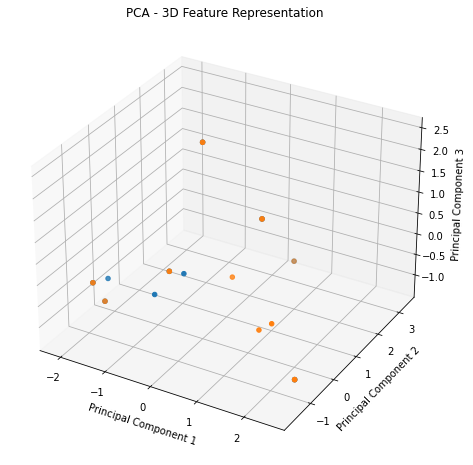

In [166]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(action_pca_df.loc[actions_with_diff, 0], action_pca_df.loc[actions_with_diff, 1], action_pca_df.loc[actions_with_diff, 2])
ax.scatter(action_pca_df.loc[actions_without_diff, 0], action_pca_df.loc[actions_without_diff, 1], action_pca_df.loc[actions_without_diff, 2])
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA - 3D Feature Representation')
plt.show()

In [133]:
for a in actions_without_diff:
  print(item_names[a])

# '多功能泡麵碗', '廚房重油汙泡沫清潔劑', '亞羅椿煥采眼霜'

薑黃維生素c b群
tommy滿版傘 藍
istkunst圓笑臉大學t 藍
gucci 復古金頭 0593
istkunst聯名nice ghost club米白色大學t
all natural仙人掌修護面膜
法拉利手錶 模型車組
ea耀眼金銀三眼錶
韓國elishacoy康普茶保濕精華
coach外圈鑽簡約錶 金


In [132]:
for a in actions_with_diff:
  print(item_names[a])

nike swoosh 腰包
istkunst聯名nice ghost club米白色大學t
tommy立領科技布外套 黑520 xl號
tommy滿版傘 藍
韓國elishacoy康普茶保濕精華
istkunst圓笑臉大學t 藍
all natural仙人掌修護面膜
istkunst聯名nice ghost club藍色帽t
薑黃維生素c b群
法拉利手錶 模型車組
